In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cbook, cm
from matplotlib.colors import LightSource

%matplotlib inline

## Problem 1: Steepest Descent
As a test function, we use

$$
f({\bf x}) = 2e^{x_{1}-.1}\cosh(3x_{2}) + e^{-x_{1}-.1}, ~ {\bf x} = (x_{1}, x_{2})
$$

One can quickly show that this has a global minimum at ${\bf x}_{\ast} = (-.5\ln(2), 0)$, and $f({\bf x}_{\ast})=2.5592666966582156$

In [3]:
def cvx_fun_plot(x1vals, x2vals):
    ex = np.exp(x1vals - .1)
    enx = np.exp(-x1vals - .1)
    ey = 2.*np.cosh(3.*x2vals)
    fun = ey[:, np.newaxis] @ ex[np.newaxis, :] + np.ones((x2vals.size,1)) @ enx[np.newaxis, :]
    return fun

In [4]:
def cvx_fun(xval):
    x1, x2 = xval[0], xval[1]
    return 2.*np.exp(x1-.1)*np.cosh(3.*x2) + np.exp(-x1-.1)

In [5]:
def grad_cvx_fun(xval):
    x1, x2 = xval[0], xval[1]
    gvec = np.zeros(2, dtype=np.float64)
    gvec[0] = 2. * np.exp(x1-.1) * np.cosh(3.*x2) - np.exp(-x1-.1)
    gvec[1] = 6. * np.exp(x1-.1) * np.sinh(3.*x2)
    return gvec

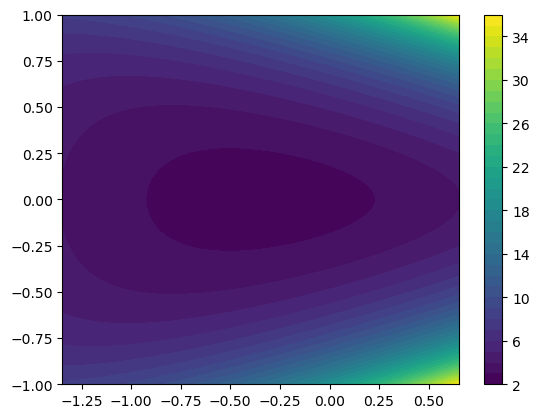

In [6]:
xstr = .5 * np.log(.5)
ystr = 0.
xvals = np.linspace(xstr - 1., xstr + 1., int(1e2)+1)
yvals = np.linspace(ystr - 1., ystr + 1., int(1e2)+1)
test_fun = cvx_fun_plot(xvals, yvals)
plt.contourf(xvals, yvals, test_fun, levels=40)
plt.colorbar()

Implement the steepest-descent update formula 

$$
{\bf x}_{k+1} = {\bf x}_{k} - \mu_{k}\nabla f({\bf x}_{k}), ~ \mu_{k} > 0
$$

with the convergence constraints

$$
f({\bf x}_{k+1}) \lt f({\bf x}_{k}), ~ \sum_{k=0}^{\infty}\mu_{k}=\infty, ~ \sum_{k=0}^{\infty}\mu^{2}_{k}\lt \infty.
$$

Given some user defined tolerance, say `tol`, we iterate until 

$$
\left|\left|\nabla f({\bf x}_{k})\right|\right| \lt \text{tol}.
$$

Choosing 100 initial conditions from the circle

$$
(x_{1} + .5\ln(2))^{2} + x_{2}^{2} = 1
$$

plot the iteration count as a function of the angle along your circle of initial conditions.  Commment on the performance of your implementation in particular with regards to how you choose your update scheme for $\mu_k$ and also how you choose your tolerance.  


In [32]:
def grad_step(xval, gvec, muval):
    return xval - muval * gvec

def steepest_descent(x0, tol):
    mu0 = 1.
    cnt = 0.
    x1tst = grad_step(x0, grad_cvx_fun(x0), mu0)

    while np.linalg.norm(grad_cvx_fun(x0)) > tol: 
        # search along gradient to find a proper descent direction
        while cvx_fun(x1tst) >= cvx_fun(x0):
            mu0 /= 2.
            x1tst = grad_step(x0, grad_cvx_fun(x0), mu0)
        x0 = x1tst
        cnt += 1
        
        # How are we going to update our steps to fit with our convergence requirements?  This is just a first suggestion.  
        # Could we pick a larger constant to make this go faster?  

        mu0 = 1./np.sqrt(cnt)
        
    return x0, cnt

def steep_descent_tester(num_angles, tol):
    x1str = .5 * np.log(.5)
    x2str = 0.
    
    angles = np.linspace(0, 2.*np.pi, num_angles)
    counts = np.zeros(num_angles, dtype=int)
    for jj in range(num_angles):
        x0 = np.array([ x1str + np.cos(angles[jj]), x2str + np.sin(angles[jj]) ]) 
        xstr, cnt = steepest_descent(x0, tol)
        counts[jj] = cnt

    plt.plot(angles, counts)


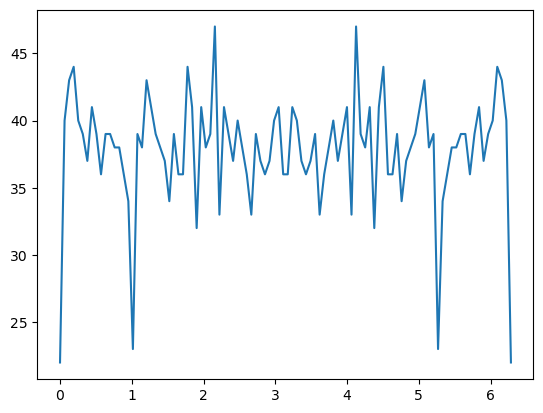

In [33]:
steep_descent_tester(100, 1e-6)

## Problem 2: Momentum to Accelerate Convergence

So we can imagine that as the steepest descent method starts to converge onto a minimum of $f({\bf x})$, it faces a landscape in which $\nabla f({\bf x})$ doesn't change much from iteration to iteration.  To take advantage of this, we add what is called *momentum* to our steepest descent update formula.  This looks like the following algorithm.

\begin{align*}
\Delta {\bf x}_{k+1} =  & a\Delta {\bf x}_{k} - \mu \nabla f({\bf x}_{k})\\
{\bf x}_{k+1} = & {\bf x}_{k} + \Delta {\bf x}_{k+1}.
\end{align*}

Here, $0<a<1$ is the *momentum term* and we now fix the step $\mu$ to be a constant (though we still need to make sure we're taking descent directions so we need to be careful about choices for this parameter).  Since $\mu$ is now a constant, we call it the *learning rate* of our descent method.    

* Show that over some **very large** number of iterations such that $\nabla f({\bf x}_{k})\approx {\bf c}$, we can solve for $\Delta {\bf x}$ so that
$$
\Delta {\bf x} \approx -\frac{\mu}{1-a}{\bf c}
$$
* What effect does the momentum then have on your method?  Why does adding momentum in effect automatically make your method have an adaptive step-size?  
* To implement this method, we suppose that $\Delta {\bf x}_{0}=0$ and we then make a choice of $a$ and $\mu$.  Code this up and explore how the iteration counts can be improved by using different choices of $\mu$ and $a$.  

In [34]:
def momentum_solver(a, mu, xj, dxj):
    dxjp1 = a*dxj - mu*grad_cvx_fun(xj)
    xjp1 = xj + dxjp1
    return xjp1, dxjp1
    
def momentum_tester(num_angles, a, mu, tol):
    x1str = .5 * np.log(.5)
    x2str = 0.
    
    angles = np.linspace(0, 2.*np.pi, num_angles)
    counts = np.zeros(num_angles, dtype=int)
    
    for jj in range(num_angles):
        x0 = np.array([ x1str + np.cos(angles[jj]), x2str + np.sin(angles[jj]) ]) 
        dx0 = np.zeros(2, dtype=np.float64)    
        x1, dx1 = momentum_solver(a, mu, x0, dx0)
        cnt = 0
        while np.linalg.norm(x1-x0) >= tol * np.linalg.norm(x0):
            x0, dx0 = x1, dx1
            x1, dx1 = momentum_solver(a, mu, x0, dx0)
            cnt += 1
        
        counts[jj] = cnt

    return counts

In [35]:
counts_a0 = momentum_tester(100, .1, 1e-2, 1e-6)
counts_a1 = momentum_tester(100, .5, 1e-2, 1e-6)
counts_a2 = momentum_tester(100, .7, 1e-2, 1e-6)

Text(0, 0.5, 'Iteration Count')

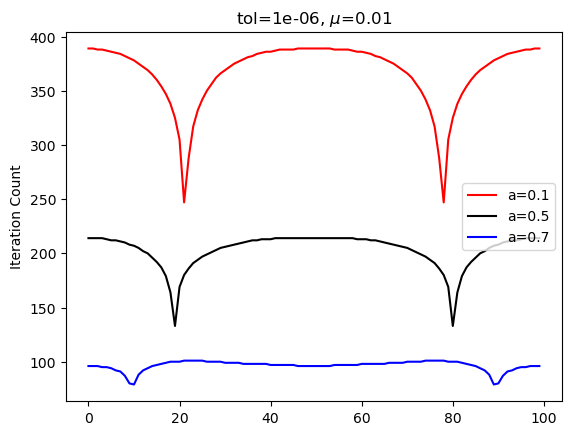

In [36]:
plt.plot(counts_a0, color='r', label=fr"a={.1}")
plt.plot(counts_a1, color='k', label=fr"a={.5}")
plt.plot(counts_a2, color='b', label=fr"a={.7}")
plt.legend()
plt.title(fr"tol={1e-6}, $\mu$={1e-2}")
plt.ylabel(r"Iteration Count")

## Problem 3 (Graduate): Epigraphs

For a function $f:\mathbb{R}^{n}\rightarrow \mathbb{R}$, we define its *epigraph* $\text{epi}(f;C)$ to be 

$$
\text{epi}(f;C) = \left\{ ({\bf x}, r)\in C \times \mathbb{R}: ~ f({\bf x}) \leq r \right\},
$$

where $C\subset \mathbb{R}^{n}$ is convex.  Show that $f$ is a convex function if and only if $\text{epi}(f)$ is a convex subset of $\mathbb{R}^{n}\times \mathbb{R}$.

## Problem 4 (Graduate): The Perceptron

In [37]:
# Let's make some data in R^3 for the Perceptron to classify.  
def hyperplane(x):
    return 1. + np.sum(np.ones(3) * x) # let's keep this simple
    
# Generate labeled data on either side of a 3D plane.
def label_maker(Npts, margin):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    points_above = []
    labels_plus = []    
    points_below = []
    labels_minus = []

    for jj in range(Npts):
        tst_point = 10.* np.random.randn(3)
        find = True
        while find:
            if hyperplane(tst_point) >= margin:
                points_above.append(tst_point)
                labels_plus.append(1)
                find = False
                ax.scatter(tst_point[0], tst_point[1], tst_point[2], c='k')
            elif hyperplane(tst_point) <= -margin:
                points_below.append(tst_point)
                labels_minus.append(-1)
                find = False
                ax.scatter(tst_point[0], tst_point[1], tst_point[2], c='r')
            else:
                tst_point = 10.* np.random.randn(3)

    xvals = np.linspace(-50., 50., int(1e1)+1)
    yvals = np.linspace(-50., 50., int(1e1)+1)
    xx, yy = np.meshgrid(xvals, yvals)
    zvals = -1 - xx - yy
    ax.plot_surface(xx, yy, zvals, linewidth=0, alpha=.25)
    return points_above, labels_plus, points_below, labels_minus

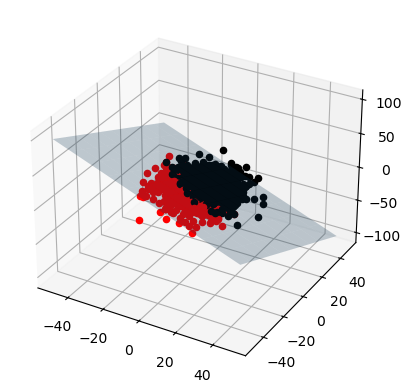

In [104]:
points_above, labels_plus, points_below, labels_minus = label_maker(1000, .01)

So, the Perceptron is the simplest neural network, which for labeled data $\left\{({\bf x}_{m},l_{m})\right\}_{m=1}^{N_{D}}$ ultimately defined by the loss function:

$$
\tilde{\mathcal{L}}(\theta, b) = \frac{1}{N_{D}}\sum_{m=1}^{N_{D}}\text{max}\left(0, -l_{m}\left(b + \left<\theta,{\bf x}_{m}\right>\right)\right)
$$

To make the next bit of analysis more straightforward, define $\tilde{{\bf x}}_{m} = ({\bf x}_{m}, 1)$ and $\tilde{\theta} = (\theta, b)$ so that 
$$
\tilde{\mathcal{L}}(\theta, b) = \frac{1}{N_{D}}\sum_{m=1}^{N_{D}}\text{max}\left(0, -\left<\tilde{\theta},l_{m}\tilde{{\bf x}}_{m}\right> \right)
$$

Likewise, define $\mathcal{L}(\tilde{\theta}; (\tilde{{\bf x}}_{m}, l_{m}))$ as 
$$
\mathcal{L}(\tilde{\theta}; (\tilde{{\bf x}}_{m}, l_{m})) = \text{max}\left(0, -\left<\tilde{\theta},l_{m}\tilde{{\bf x}}_{m}\right> \right)
$$

**Part 1**: Show that $\partial_{\tilde{\theta}} \mathcal{L}(\tilde{\theta}; (\tilde{{\bf x}}_{m}, l_{m}))$ is given by
$$
\partial_{\tilde{\theta}} \mathcal{L}(\tilde{\theta}; (\tilde{{\bf x}}_{m}, l_{m})) = \left\{
    \begin{array}{rl}
    0 & \left<\tilde{\theta},l_{m}\tilde{{\bf x}}_{m}\right>   \gt 0 \\
    & \\
    -l_{m}\tilde{{\bf x}}_{m} & \left<\tilde{\theta},l_{m} \tilde{{\bf x}}_{m}\right> \lt 0\\
    & \\
    \frac{1}{2}(r-1)l_{m}\tilde{{\bf x}}_{m} & \left<\tilde{\theta},l_{m} \tilde{{\bf x}}_{m}\right> = 0, ~ -1\leq r \leq 1
    \end{array}
    \right.
$$
To do this, remember that
$$
\mathcal{L}(\tilde{\theta}; (\tilde{{\bf x}}_{m}, l_{m})) = -\frac{1}{2}\left<\tilde{\theta},l_{m}\tilde{{\bf x}}_{m}\right> + \frac{1}{2}\left|\left<\tilde{\theta},l_{m}\tilde{{\bf x}}_{m}\right> \right|
$$
and then remember back to how we differentiated $|x|$ and then use the chain rule.

**Part 2**: Choosing $r=-1$, show that the steepest-descent step becomes 

$$
\tilde{\theta}_{k+1} = \tilde{\theta}_{k} + \frac{\mu_{k}}{N_{D}}\sum_{m=1}^{N_{D}}l_{m}\tilde{{\bf x}}_{m} I_{(-\infty, 0]}\left(\left<\tilde{\theta}_{k},l_{m}\tilde{{\bf x}}_{m}\right>\right), ~ \mu_{k} \gt 0,
$$

where $I_{(-\infty, 0]}(t)$ is the indicator function.

**Part 3**: Using the data generation method above, implement the steepest-descent method for the Perceptron.  Does the number of iterations the method takes to converge change based on your choice of $\mu_{k}$?

In [105]:
Nd = len(points_above) + len(points_below)
dim = points_above[0].size
data_mat = np.ones((dim+1, Nd))
data_mat[:dim, :len(points_above)] = np.array(points_above).T @ np.diag(labels_plus)
data_mat[dim, :len(points_above)] = labels_plus
data_mat[:dim, len(points_above):] = np.array(points_below).T @ np.diag(labels_minus)
data_mat[dim, len(points_above):] = labels_minus

In [106]:
def perceptron_step(theta0, data_mat, mu):
    innerp = theta0.T @ data_mat
    indskp = innerp <= 0.
    grad = mu*np.sum(data_mat[:,indskp.squeeze()],axis=1)/data_mat.shape[1]
    theta1 = theta0 + mu*grad[:,np.newaxis]
    return theta1

In [108]:
mu = 1.
tol = 1e-3

theta0 = np.zeros((dim+1, 1), dtype=np.float64)
theta1 = perceptron_step(theta0, data_mat, mu)
cnt = 0

while np.linalg.norm(theta1-theta0) >= tol * np.linalg.norm(theta0):
    theta0 = theta1
    theta1 = perceptron_step(theta0, data_mat, mu)
    cnt += 1

print(theta1)
print(cnt)

[[3.8503495 ]
 [3.78153694]
 [3.84477619]
 [3.176     ]]
232
